# 第8章 提升方法

1．提升方法是将弱学习算法提升为强学习算法的统计学习方法。在分类学习中，提升方法通过反复修改训练数据的权值分布，构建一系列基本分类器（弱分类器），并将这些基本分类器线性组合，构成一个强分类器。代表性的提升方法是AdaBoost算法。

AdaBoost模型是弱分类器的线性组合：

$$f(x)=\sum_{m=1}^{M} \alpha_{m} G_{m}(x)$$

2．AdaBoost算法的特点是通过迭代每次学习一个基本分类器。每次迭代中，提高那些被前一轮分类器错误分类数据的权值，而降低那些被正确分类的数据的权值。最后，AdaBoost将基本分类器的线性组合作为强分类器，其中给分类误差率小的基本分类器以大的权值，给分类误差率大的基本分类器以小的权值。

3．AdaBoost的训练误差分析表明，AdaBoost的每次迭代可以减少它在训练数据集上的分类误差率，这说明了它作为提升方法的有效性。

4．AdaBoost算法的一个解释是该算法实际是前向分步算法的一个实现。在这个方法里，模型是加法模型，损失函数是指数损失，算法是前向分步算法。
每一步中极小化损失函数

$$\left(\beta_{m}, \gamma_{m}\right)=\arg \min _{\beta, \gamma} \sum_{i=1}^{N} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+\beta b\left(x_{i} ; \gamma\right)\right)$$

得 到 参 数$\beta_{m}, \gamma_{m}$。

5．提升树是以分类树或回归树为基本分类器的提升方法。提升树被认为是统计学习中最有效的方法之一。


# Boost

“装袋”（bagging）和“提升”（boost）是构建组合模型的两种最主要的方法，所谓的组合模型是由多个基本模型构成的模型，组合模型的预测效果往往比任意一个基本模型的效果都要好。

- 装袋：每个基本模型由从总体样本中随机抽样得到的不同数据集进行训练得到，通过重抽样得到不同训练数据集的过程称为装袋。

- 提升：每个基本模型训练时的数据集采用不同权重，针对上一个基本模型分类错误的样本增加权重，使得新的模型重点关注误分类样本

### AdaBoost

AdaBoost是AdaptiveBoost的缩写，表明该算法是具有适应性的提升算法。

算法的步骤如下：

1）给每个训练样本（$x_{1},x_{2},….,x_{N}$）分配权重，初始权重$w_{1}$均为1/N。

2）针对带有权值的样本进行训练，得到模型$G_m$（初始模型为G1）。

3）计算模型$G_m$的误分率$e_m=\sum_{i=1}^Nw_iI(y_i\not= G_m(x_i))$

4）计算模型$G_m$的系数$\alpha_m=0.5\log[(1-e_m)/e_m]$

5）根据误分率e和当前权重向量$w_m$更新权重向量$w_{m+1}$。

6）计算组合模型$f(x)=\sum_{m=1}^M\alpha_mG_m(x_i)$的误分率。

7）当组合模型的误分率或迭代次数低于一定阈值，停止迭代；否则，回到步骤2）

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [3]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

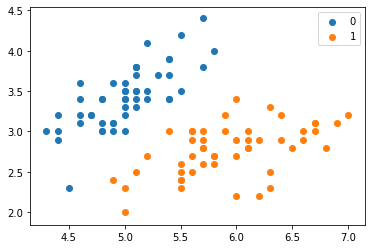

In [4]:
plt.scatter(X[:50,0],X[:50,1], label='0')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

----

### AdaBoost in Python

In [5]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.clf_num = n_estimators
        self.learning_rate = learning_rate

    def init_args(self, datasets, labels):

        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape

        # 弱分类器数目和集合
        self.clf_sets = []

        # 初始化weights
        self.weights = [1.0 / self.M] * self.M

        # G(x)系数 alpha
        self.alpha = []

    def _G(self, features, labels, weights):
        m = len(features)
        error = 100000.0  # 无穷大
        best_v = 0.0
        # 单维features
        features_min = min(features)
        features_max = max(features)
        n_step = (features_max - features_min +
                  self.learning_rate) // self.learning_rate
        # print('n_step:{}'.format(n_step))
        direct, compare_array = None, None
        for i in range(1, int(n_step)):
            v = features_min + self.learning_rate * i

            if v not in features:
                # 误分类计算
                compare_array_positive = np.array(
                    [1 if features[k] > v else -1 for k in range(m)])
                weight_error_positive = sum([
                    weights[k] for k in range(m)
                    if compare_array_positive[k] != labels[k]
                ])

                compare_array_nagetive = np.array(
                    [-1 if features[k] > v else 1 for k in range(m)])
                weight_error_nagetive = sum([
                    weights[k] for k in range(m)
                    if compare_array_nagetive[k] != labels[k]
                ])

                if weight_error_positive < weight_error_nagetive:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_nagetive
                    _compare_array = compare_array_nagetive
                    direct = 'nagetive'

                # print('v:{} error:{}'.format(v, weight_error))
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
        return best_v, direct, error, compare_array

    # 计算alpha
    def _alpha(self, error):
        return 0.5 * np.log((1 - error) / error)

    # 规范化因子
    def _Z(self, weights, a, clf):
        return sum([
            weights[i] * np.exp(-1 * a * self.Y[i] * clf[i])
            for i in range(self.M)
        ])

    # 权值更新
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i] * np.exp(
                -1 * a * self.Y[i] * clf[i]) / Z

    # G(x)的线性组合
    def _f(self, alpha, clf_sets):
        pass

    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1
        else:
            return -1 if x > v else 1

    def fit(self, X, y):
        self.init_args(X, y)

        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result = 100000, None, None
            # 根据特征维度, 选择误差最小的
            for j in range(self.N):
                features = self.X[:, j]
                # 分类阈值，分类误差，分类结果
                v, direct, error, compare_array = self._G(
                    features, self.Y, self.weights)

                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j

                # print('epoch:{}/{} feature:{} error:{} v:{}'.format(epoch, self.clf_num, j, error, best_v))
                if best_clf_error == 0:
                    break

            # 计算G(x)系数a
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            # 记录分类器
            self.clf_sets.append((axis, best_v, final_direct))
            # 规范化因子
            Z = self._Z(self.weights, a, clf_result)
            # 权值更新
            self._w(a, clf_result, Z)


#             print('classifier:{}/{} error:{:.3f} v:{} direct:{} a:{:.5f}'.format(epoch+1, self.clf_num, error, best_v, final_direct, a))
#             print('weight:{}'.format(self.weights))
#             print('\n')

    def predict(self, feature):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        # sign
        return 1 if result > 0 else -1

    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1

        return right_count / len(X_test)

### 例8.1

In [6]:
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

In [7]:
clf = AdaBoost(n_estimators=3, learning_rate=0.5)
clf.fit(X, y)

In [8]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [9]:
clf = AdaBoost(n_estimators=10, learning_rate=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5151515151515151

In [10]:
# 100次结果
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost(n_estimators=100, learning_rate=0.2)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    # print('{}/100 score：{}'.format(i, r))
    result.append(r)

print('average score:{:.3f}%'.format(sum(result)))

average score:63.394%


### scikit-learn实例

-----
#### sklearn.ensemble.AdaBoostClassifier

- algorithm：这个参数只有AdaBoostClassifier有。主要原因是scikit-learn实现了两种Adaboost分类算法，SAMME和SAMME.R。两者的主要区别是弱学习器权重的度量，SAMME使用了和我们的原理篇里二元分类Adaboost算法的扩展，即用对样本集分类效果作为弱学习器权重，而SAMME.R使用了对样本集分类的预测概率大小来作为弱学习器权重。由于SAMME.R使用了概率度量的连续值，迭代一般比SAMME快，因此AdaBoostClassifier的默认算法algorithm的值也是SAMME.R。我们一般使用默认的SAMME.R就够了，但是要注意的是使用了SAMME.R， 则弱分类学习器参数base_estimator必须限制使用支持概率预测的分类器。SAMME算法则没有这个限制。


- n_estimators： AdaBoostClassifier和AdaBoostRegressor都有，就是我们的弱学习器的最大迭代次数，或者说最大的弱学习器的个数。一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，一般选择一个适中的数值。默认是50。在实际调参的过程中，我们常常将n_estimators和下面介绍的参数learning_rate一起考虑。


-  learning_rate:  AdaBoostClassifier和AdaBoostRegressor都有，即每个弱学习器的权重缩减系数ν


- base_estimator：AdaBoostClassifier和AdaBoostRegressor都有，即我们的弱分类学习器或者弱回归学习器。理论上可以选择任何一个分类或者回归学习器，不过需要支持样本权重。我们常用的一般是CART决策树或者神经网络MLP。

In [11]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.5, n_estimators=100)

In [12]:
clf.score(X_test, y_test)

0.9090909090909091

## 第8章提升方法-习题

### 习题8.1
&emsp;&emsp;某公司招聘职员考查身体、业务能力、发展潜力这3项。身体分为合格1、不合格0两级，业务能力和发展潜力分为上1、中2、下3三级分类为合格1 、不合格-1两类。已知10个人的数据，如下表所示。假设弱分类器为决策树桩。试用AdaBoost算法学习一个强分类器。  

应聘人员情况数据表

&emsp;&emsp;|1|2|3|4|5|6|7|8|9|10
-|-|-|-|-|-|-|-|-|-|-
身体|0|0|1|1|1|0|1|1|1|0
业务|1|3|2|1|2|1|1|1|3|2
潜力|3|1|2|3|3|2|2|1|1|1
分类|-1|-1|-1|-1|-1|-1|1|1|-1|-1

In [13]:
import numpy as np

# 加载训练数据
X = np.array([[0, 1, 3], [0, 3, 1], [1, 2, 2], [1, 1, 3], [1, 2, 3], [0, 1, 2],
              [1, 1, 2], [1, 1, 1], [1, 3, 1], [0, 2, 1]])
y = np.array([-1, -1, -1, -1, -1, -1, 1, 1, -1, -1])

**AdaBoostClassifier分类器实现：**

采用sklearn的AdaBoostClassifier分类器直接求解，由于AdaBoostClassifier分类器默认采用CART决策树弱分类器，故不需要设置base_estimator参数。

In [14]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X, y)
y_predict = clf.predict(X)
score = clf.score(X, y)
print("原始输出:", y)
print("预测输出:", y_predict)
print("预测正确率：{:.2%}".format(score))

原始输出: [-1 -1 -1 -1 -1 -1  1  1 -1 -1]
预测输出: [-1 -1 -1 -1 -1 -1  1  1 -1 -1]
预测正确率：100.00%


**自编程实现：**

In [15]:
# 自编程求解例8.1
import numpy as np


class AdaBoost:
    def __init__(self, X, y, tol=0.05, max_iter=10):
        # 训练数据 实例
        self.X = X
        # 训练数据 标签
        self.y = y
        # 训练中止条件 right_rate>self.tol
        self.tol = tol
        # 最大迭代次数
        self.max_iter = max_iter
        # 初始化样本权重w
        self.w = np.full((X.shape[0]), 1 / X.shape[0])
        self.G = []  # 弱分类器

    def build_stump(self):
        """
        以带权重的分类误差最小为目标，选择最佳分类阈值
        best_stump['dim'] 合适的特征所在维度
        best_stump['thresh']  合适特征的阈值
        best_stump['ineq']  树桩分类的标识lt,rt
        """
        m, n = np.shape(self.X)
        # 分类误差
        e_min = np.inf
        # 小于分类阈值的样本属于的标签类别
        sign = None
        # 最优分类树桩
        best_stump = {}
        for i in range(n):
            range_min = self.X[:, i].min()  # 求每一种特征的最大最小值
            range_max = self.X[:, i].max()
            step_size = (range_max - range_min) / n
            for j in range(-1, int(n) + 1):
                thresh_val = range_min + j * step_size
                # 计算左子树和右子树的误差
                for inequal in ['lt', 'rt']:
                    predict_vals = self.base_estimator(self.X, i, thresh_val,
                                                       inequal)
                    err_arr = np.array(np.ones(m))
                    err_arr[predict_vals.T == self.y.T] = 0
                    weighted_error = np.dot(self.w, err_arr)
                    if weighted_error < e_min:
                        e_min = weighted_error
                        sign = predict_vals
                        best_stump['dim'] = i
                        best_stump['thresh'] = thresh_val
                        best_stump['ineq'] = inequal
        return best_stump, sign, e_min

    def updata_w(self, alpha, predict):
        """
        更新样本权重w
        """
        # 以下2行根据公式8.4 8.5 更新样本权重
        P = self.w * np.exp(-alpha * self.y * predict)
        self.w = P / P.sum()

    @staticmethod
    def base_estimator(X, dimen, threshVal, threshIneq):
        """
        计算单个弱分类器（决策树桩）预测输出
        """
        ret_array = np.ones(np.shape(X)[0])  # 预测矩阵
        # 左叶子 ，整个矩阵的样本进行比较赋值
        if threshIneq == 'lt':
            ret_array[X[:, dimen] <= threshVal] = -1.0
        else:
            ret_array[X[:, dimen] > threshVal] = -1.0
        return ret_array

    def fit(self):
        """
        对训练数据进行学习
        """
        G = 0
        for i in range(self.max_iter):
            best_stump, sign, error = self.build_stump()  # 获取当前迭代最佳分类阈值
            alpha = 1 / 2 * np.log((1 - error) / error)  # 计算本轮弱分类器的系数
            # 弱分类器权重
            best_stump['alpha'] = alpha
            # 保存弱分类器
            self.G.append(best_stump)
            # 以下3行计算当前总分类器（之前所有弱分类器加权和）分类效率
            G += alpha * sign
            y_predict = np.sign(G)
            error_rate = np.sum(
                np.abs(y_predict - self.y)) / 2 / self.y.shape[0]
            if error_rate < self.tol:  # 满足中止条件 则跳出循环
                print("迭代次数:", i + 1)
                break
            else:
                self.updata_w(alpha, y_predict)  # 若不满足，更新权重，继续迭代

    def predict(self, X):
        """
        对新数据进行预测
        """
        m = np.shape(X)[0]
        G = np.zeros(m)
        for i in range(len(self.G)):
            stump = self.G[i]
            # 遍历每一个弱分类器，进行加权
            _G = self.base_estimator(X, stump['dim'], stump['thresh'],
                                     stump['ineq'])
            alpha = stump['alpha']
            G += alpha * _G
        y_predict = np.sign(G)
        return y_predict.astype(int)

    def score(self, X, y):
        """对训练效果进行评价"""
        y_predict = self.predict(X)
        error_rate = np.sum(np.abs(y_predict - y)) / 2 / y.shape[0]
        return 1 - error_rate

In [16]:
clf = AdaBoost(X, y)
clf.fit()
y_predict = clf.predict(X)
score = clf.score(X, y)
print("原始输出:", y)
print("预测输出:", y_predict)
print("预测正确率：{:.2%}".format(score))

迭代次数: 8
原始输出: [-1 -1 -1 -1 -1 -1  1  1 -1 -1]
预测输出: [-1 -1 -1 -1 -1 -1  1  1 -1 -1]
预测正确率：100.00%


### 习题8.2
&emsp;&emsp;比较支持向量机、 AdaBoost 、Logistic回归模型的学习策略与算法

**解答：**  
- **支持向量机**  
学习策略：极小化正则化合页损失，软间隔最大化；  
学习算法：序列最小最优化算法（SMO）  
- **AdaBoost**  
学习策略：极小化加法模型指数损失；  
学习算法：前向分步加法算法  
- **Logistic回归**  
学习策略：极大似然估计，正则化的极大似然估计；  
学习算法：改进的迭代尺度算法，梯度下降，拟牛顿法

----
参考代码：https://github.com/wzyonggege/statistical-learning-method

本文代码更新地址：https://github.com/fengdu78/lihang-code

习题解答：https://github.com/datawhalechina/statistical-learning-method-solutions-manual

中文注释制作：机器学习初学者公众号：ID:ai-start-com

配置环境：python 3.5+

代码全部测试通过。
![gongzhong](../gongzhong.jpg)